# Investigating PM2.5 Levels in Newcastle Using Urban Observatory Data and Building a Forecasting Model to Predict Future PM2.5 Levels


Created by Daniel Godden

## 1. Introduction and Objectives of Project

 ### 1.1. Introduction

What is the Urban Observatory? Newcastle University’s Urban Observatory is a smart city data monitoring centre, which collects large amounts of real-time data on various themes, such as air pollution, sound pollution, and traffic flow [1]. It is funded in partnership with UKCRIC, the UK Collaboration for Research on Infrastructure and Cities, and holds the largest set of open environmental monitoring data in the world [2]. The Urban Observatory has the largest deployment of sensors in the UK, with Newcastle (and Gateshead) alone, with over 1000 sensors measuring 60 different environmental indicators. This, along with the fact that it is all open source, makes Newcastle University’s Urban Observatory a powerful tool for analysing urban data. These sensors make in total around 2000 observations a minute, and to date have made over 900,000,000 observations [3].

PM2.5 refers to atmospheric particulate matter with a diameter of 2.5 micrometres or less [4]. These particles can arise from various sources such as road transport, industrial processes, and manufacturing. This link can be shown clearly with a study finding a drop in PM2.5 levels as transport flow levels decreased during the COVID pandemic [5]. Due to this particle being small and light, it tends to stay longer in the air and can enter people's bodies through their circulatory system. Studies have found a close link between exposure to PM2.5 and death from heart and lung disease [6]. It also has been shown that conditions such as asthma, heart attacks and other respiratory problems can become worse from exposure to PM2.5.
Studies have also shown that long-term exposure to PM2.5 may lead to problems such as vascular inflammation and strokes [7]. In the study conducted by the Journal of the American Medical Association, scientists found that for every 10 micrograms per cubic meter increase in PM2.5 air pollution, there is an associated 4%, 6% and 8% increased risk of all-cause, cardiopulmonary and lung cancer mortality, respectively [8]. An association between mothers' exposure to PM2.5 and birth defects has also been established by several reports [9].

Due to the commonality of health authorities measuring PM2.5 to better understand air quality, the index of PM2.5 is often given alongside the Air Quality Index (AQI) [10], as seen in the table below. This table was published by the U.S. Environmental Protection Agency, but similar results are published by health organisations around the world. It provides a guide to safe and unsafe levels of PM2.5, which is what will be used in the project to investigate air pollution in Newcastle.

This project will aim to provide a interactable front-end for a user to be able to analyse PM2.5 levels using a forecasting model. This will allow the user to predict if levels might reach above "safe" levels. Data has been collected from April 2023 and will be used to train the model. The model will be set up so it can be retrained with new data to improve the quality of results. 

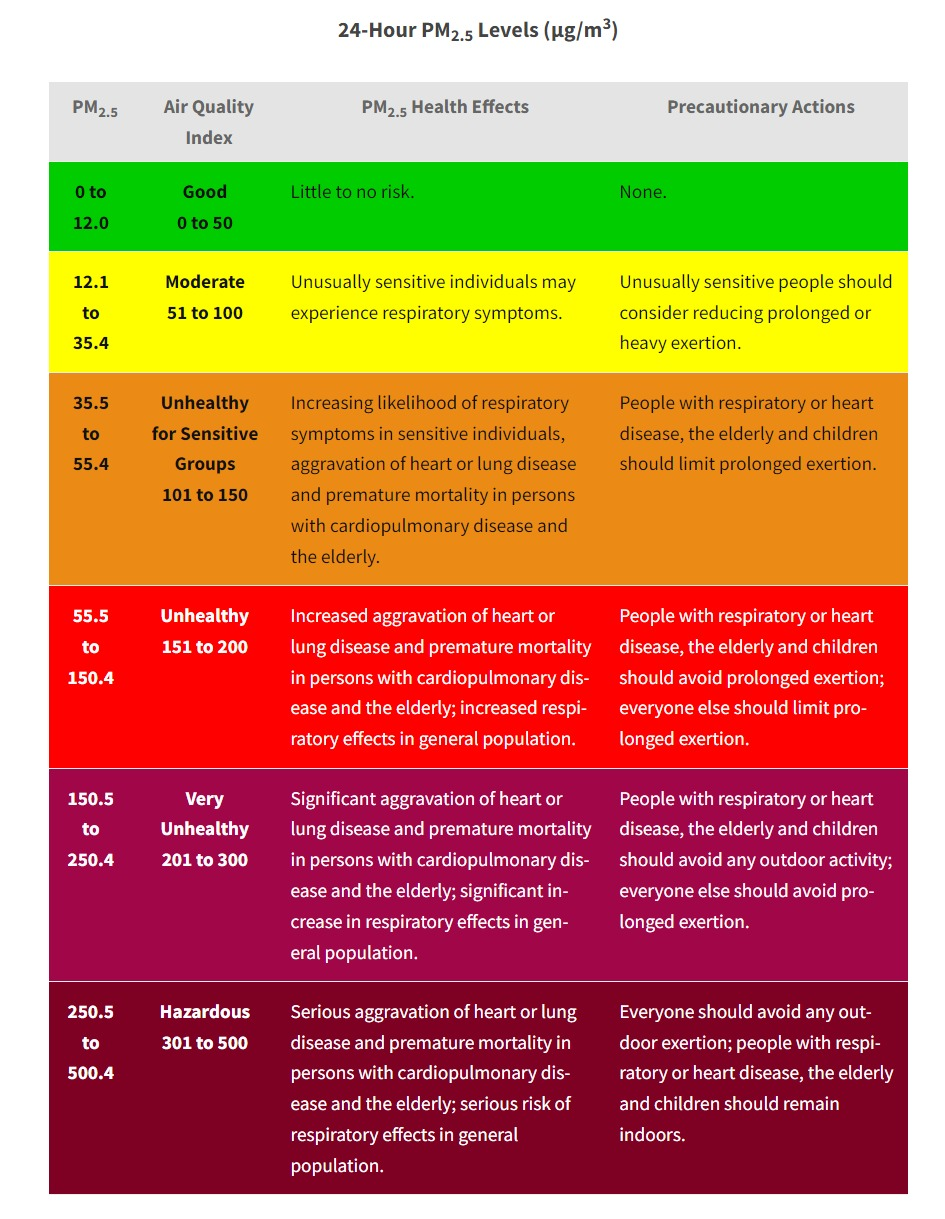

### 1.2. Objectives

This project aims to find regions of Newcastle where the PM2.5 levels are categorised as "unhealthy" or "hazardous". In this preliminary stage, the data will be prepared for analysis. PM2.5 sensor data will be parsed into a Pandas dataframe and then cleaned ready for analysis. The cleaning procedure will involve checking for suspect readings (where the reading is zero) and replacing them with the mean average value. After that, the outliers will be resolved. This will be done by finding outliers that are a multiple of the standard deviation and replacing them with the mean average value. By removing the outliers, the outputs produced will better reflect normal levels of PM2.5 for that area. That is, what an average day-to-day expected range is, ignoring events which may cause unusual spikes (events that lead to much higher traffic flow than usual, such as a festival).

This project aims to provide a clear picture of the levels of PM2.5 in Newcastle. The hope is that the historical data collected can provide a picture of the current state of PM2.5 levels, and a predictive model can extend that with what the expected levels will be over the next 30 days.It is worth noting that PM2.5 is but one of the many particulates that affect air quality. The reason for choosing the work only with PM2.5 is firstly to simplify the analysis, but also due to its well documented health affects, as well as its links to manufacturing and traffic. It will be of interest to see what areas of Newcastle are most heavily effected, and whether these areas have congested roads or manufacturing facilities.

## 2. Data Collection and Processing of Data

### 2.1. Data Collection

The data was collected from Newcastle University's Urban Observatory's API. A GET request was made to parse all "PM2.5 data into a Pandas dataframe. Due to the limitations of how much can be parsed at once, we request a month at a time. All the data will then be collected as a single dataset and saved to a csv called "master.csv". Information on accessing Newcastle Univercity's Urban Observatory API can be found using this link:https://newcastle.urbanobservatory.ac.uk/api_docs/

In [ ]:
# import libraries for data loading
import requests
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
from scipy.stats import pearsonr

In [ ]:
# Define the sets of start and end variables
sets = [

    ("20230401", "20230430", "Apr23"),
    ("20230501", "20230531", "May23"),
    ("20230601", "20230630", "Jun23"),
    ("20230701", "20230731", "Jul23"),
    ("20230801", "20230831", "Aug23"),
    ("20230901", "20230926", "Sep23"),
    ("231001", "20231031", "Oct23"),
    ("231101", "20231116", "Nov23")
]

dfs = {}

# Iterate over each set of start, end, and month
for start, end, month in sets:
    # Make a GET request to the API
    response = requests.get("https://newcastle.urbanobservatory.ac.uk/api/v1.1/sensors/data/csv/?starttime=" + start + "&endtime=" + end + "&data_variable=PM2.5")

    # Check if the request was successful (status code 200 indicates success)
    if response.status_code == 200:
        # Access the response data
        df = pd.read_csv(io.StringIO(response.text))

    # Store the DataFrame in the dictionary with a key based on the month
    dfs[month] = df
    
sensor_data = pd.concat(dfs.values(), ignore_index=True)

In [ ]:
# output the first 5 rows of the parsed data
sensor_data.head()

The data above shows various instances of data collection from sensors. There are the names and locations of the sensors, as well as the variables and units of those variables. Values for each reading are given, along with the timestamp of those readings. As there is a 'Raw ID' column, providing a unique ID for each sensor, the columns: 'Broker Name', 'Third Party', and 'Flagged as Suspect Reading' columns can be dropped. This is because these columns will not contribute to the analysis in this project. 'Sensor Name' will be kept to make it easier to read for those looking through the data.

In [ ]:
# select columns to drop
columns_to_drop = ['Broker Name', 'Third Party', 'Flagged as Suspect Reading']
sensor_data = sensor_data.drop(columns_to_drop, axis=1)

#### How mant sensors are there?

In [ ]:
# count how many unique sensors there are
sensor_count = sensor_data["Sensor Name"].nunique()
sensor_count

In [ ]:
# print out names of all sensors
sensors = sensor_data["Sensor Name"].unique()
sensors

Lets analyse one sensor for now:

In [ ]:
df_sensor = sensor_data[sensor_data["Sensor Name"]==]

**What datatypes are in this dataset?**

The type of objects in this dataframe can be ascertained using the .info() object. Along with this, it is useful to use the .describe() object to utilise Pandas' ability to quickly attain descriptive statistics from the data.

In [ ]:
df_sensor.info()

**Descriptive statistics of the data**

Now let's run a quick check of the basic statistical information in the data. This includes the count, mean, and standard deviation.

In [ ]:
df_sensor.describe()

### 2.2. Data Cleaning 

Now that the data has been parsed into a pandas dataframe, the data needs to be processed. This is to ensure that the data quality is such, that useful analysis can be performed using the data. Note, knowledge of the dataset is essential when cleaning data. If what first appears to be an outlier, in fact has a pattern of occurance, it might not be an outlier. It is important to ensure you do not remove real data.
  
One way data can be cleaned is to remove suspect reading. That is, if a reading is 0.000, it  might be an error witht the sensor (as zero readings don't make sense for continous air pollutant data). It is important to note that it could be down to the sensitivity of the sensor. If the sensor cannot pickup minute readings, then it might return a value of zero. If we decide to remove zero values, one way would be to replaced them with the mean value. Secondly, outliers can be replaced with the mean value. This is to ensure that the dataset reflects normal levels of PM2.5 for that area and is not skewed by random events, such as a  one-off festival. Again, it is important to realise what is an outlier and what isn't, and whether it is wise to remove any data. Finally, a new column will be created that is populated with standardised values from the Value column. That is, the values will be transformed to be in the range 0 to 1. This is a standard practice and can help assist with further analysis.
  
It is important to note that due to the data being made up of multiple sensors, the cleaning would need to be applied to each individually (to ensure mean value is correctly calculated). The final data is not cleaned using these methods, so this is only for explanatory purposes. 

**Removing Suspect Readings**

The first thing that will be investigated will be if there are any suspect readings in the "Value" column. It would be suspect if there was a reading of 0.

In [ ]:
zero_readings = df_sensor[df_sensor['Value']==0.000]
zero_readings

These values are now going to be replaced with the mean averages of the "Value" column. This will produce data that is more realistic.

In [ ]:
# calculate the mean of the column (excluding the 0.000 values)
mean_value = df_sensor[df_sensor['Value'] != 0.000]['Value'].mean()
mean_value

In [ ]:
'''
For loop for iterating over data and replacing 0.000 values with the mean_value produced above.

'''

# Iterate over the rows of the dataframe
for index, row in df_sensor.iterrows():
    # Check if the value in "Value" column is 0.000
    if row["Value"] == 0.000:
        # Replace 0.000 with the calculated mean value
        df_sensor.at[index, 'Value'] = mean_value
else:
    print("suspect values resolved")

In [ ]:
df_sensor.head()

**Checking For Outliers**

We need to check for outliers for all individual sensors. The reason for this is so we don't end up removing what is perceived as an outlier for the total dataset, but is actually within reason for the individual sensor.

In [ ]:
count_of_rows = len(df_sensor)
print(f"df_sensor has {count_of_rows} rows.")

Now we can derive some statistical values from each sensor and remove outliers.

In [ ]:
std = np.std(df_sensor["Value"])
mean = np.mean(df_sensor["Value"])

# Replace values over 3 * std with the mean
df_sensor["Value"] = np.where(df_sensor["Value"] > mean + 3 * std, mean, df_sensor["Value"])

### 2.3. Checking autocorrelation of dataset 

Autocorrelation in the context of time series analysis refers to the correlation of a time series with a lagged version of itself. In simpler terms, it's a measure of how a series is correlated with a delayed (lagged) version of itself.

As can be seen in the graph below, there is a gradual decrease in autocorrelation as the lag increases indicates a gradual fading of the effect of previous values on the current value, which is typical in many time series. There are two points that can be understood from this graph. Firstly, there is autocorrelation. If the values were close to zero for all lags, it suggests that the time series may be a white noise process, meaning each data point is independent and has no relationship with previous points. Secondly, there is no distinct seasonality trends, which would be seen in periodic increases in the chart. This is to be expected from a non-linear dataset such as the one we are using. 

In [ ]:
data = df_sensor["Value"]

# Calculate autocovariance at different lags
def autocovariance(series, lag):
    n = len(series)
    mean = np.mean(series)
    acov = np.sum((series[lag:] - mean) * (series[:n-lag] - mean)) / n
    return acov

# Calculate autocorrelation at different lags
def autocorrelation(series, lag):
    var_0 = autocovariance(series, 0)
    if var_0 == 0:
        return 0
    return autocovariance(series, lag) / var_0

# Number of lags to consider for autocorrelation
max_lag = 20

# Calculate autocorrelation for each lag
lags = range(max_lag + 1)
autocorr_values = [autocorrelation(data.values, lag) for lag in lags]

# Plot autocorrelation function (ACF)
plt.figure(figsize=(12, 6))
plt.stem(lags, autocorr_values, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

## 3. Forecasting Model

### 3.1. Prophet 

Prophet is an open-source forecasting tool developed by Facebook. It impliments an automated process of applying an additive time series forecasting model to univariate data. It is particularly effective way of forecasting with minimal knowledge on the underlying techniques. It is also effective at handling trends, seasonality, and holidays etc. 

In [ ]:
# Create the data for the columns
x = pd.to_datetime(df_sensor["Timestamp"])
y = df_sensor.Value

# Create a dictionary with the data for each column
data = {'ds': x, 'y': y}

# Create the DataFrame
df = pd.DataFrame(data)
 

In [ ]:
from prophet import Prophet

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Predict the test data
forecast = model.predict(test_data.drop('y', axis=1))

# Plot the test data with the predicted test data
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Test Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Test Data', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

# Calculate and print RMSE for the predicted test data
test_rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
print('Test RMSE:', test_rmse)

# Create a DataFrame for future dates you want to forecast
future_dates = model.make_future_dataframe(periods=30)  # Forecasting 30 days into the future

# Make predictions for the future dates
forecast = model.predict(future_dates)

# Plot the forecasted values along with uncertainty range
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast')
plt.show()

### 3.2. Ensemble

In this section an ensemble of SARIMAX, XGBOOST and Prophet are used to try improve the accuracy of the forecast. 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

# Define the train and test data
train_data = df_sensor[:-30]  # All data except the last 30 days
test_data = df_sensor[-30:]   # The last 30 days

# Prophet model
prophet_model = Prophet()
prophet_model.fit(train_data.rename(columns={'Timestamp': 'ds', 'Value': 'y'}))
prophet_forecast = prophet_model.predict(pd.DataFrame({'ds': pd.date_range(df['Timestamp'].iloc[-30], periods=14, freq='D')}))['yhat']

# XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(np.arange(len(train_data)).reshape(-1, 1), train_data['Value'])
xgb_forecast = xgb_model.predict(np.arange(len(df), len(df) + 14).reshape(-1, 1))

# SARIMAX model
sarimax_model = SARIMAX(train_data['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_model_fit = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_model_fit.forecast(steps=14)

# Calculate the average of the predictions
average_forecast = np.mean([prophet_forecast, xgb_forecast, sarimax_forecast], axis=0)

# Plot for previous 30 days, forecast for the next 14 days, and the average forecast
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(df['Timestamp'][-44:], df['Value'][-44:], label='Previous 30 Days Data', color='red', linestyle='--')
plt.plot(pd.date_range(df['Timestamp'].iloc[-30], periods=14, freq='D'), prophet_forecast, label='Prophet Forecast (Next 14 Days)')
plt.plot(pd.date_range(df['Timestamp'].iloc[-30], periods=14, freq='D'), xgb_forecast, label='XGBoost Forecast (Next 14 Days)')
plt.plot(pd.date_range(df['Timestamp'].iloc[-30], periods=14, freq='D'), sarimax_forecast, label='SARIMAX Forecast (Next 14 Days)')
plt.plot(pd.date_range(df['Timestamp'].iloc[-30], periods=14, freq='D'), average_forecast, label='Average Forecast (Next 14 Days)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()

plt.tight_layout()
plt.show()

### 3.2. Long Short-Term Memory (LSTM) Model

LSTM is a type of recurrent neural network (RNN) architecture. This is a more advanced (and hands-on) technique that can be used for forecasting data. They are commonly used in forecasting analysis due to their ability to capture long-term dependencies in sequential data.

In [ ]:
# Prepare the data for LSTM
scaler = MinMaxScaler()
data = df_sensor['Value'].values.reshape(-1, 1)
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length (adjust as needed)
sequence_length = 10

# Create sequences for LSTM
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Predict using the LSTM model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform predictions to original scale
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'][:len(y_train_pred_inv)], df['Value'][:len(y_train_pred_inv)], label='Train Data')
plt.plot(df['Timestamp'][len(y_train_pred_inv)+sequence_length:len(y_train_pred_inv)+sequence_length+len(y_test_pred_inv)], df['Value'][len(y_train_pred_inv)+sequence_length:len(y_train_pred_inv)+sequence_length+len(y_test_pred_inv)], label='Test Data')
plt.plot(df['Timestamp'][:len(y_train_pred_inv)], y_train_pred_inv, label='Train Predictions')
plt.plot(df['Timestamp'][len(y_train_pred_inv)+sequence_length:len(y_train_pred_inv)+sequence_length+len(y_test_pred_inv)], y_test_pred_inv, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

Now the model is fitted, it can be used to predict future levels.

In [ ]:
# Prepare the last available data for prediction
last_data = df_sensor['Value'].values.reshape(-1, 1)
last_data_scaled = scaler.transform(last_data)  # Scale the data using the existing scaler

# Create sequences for prediction
X_pred, _ = create_sequences(last_data_scaled, sequence_length)
X_pred = X_pred[-1]  # Take the last sequence for prediction

# Predict the next 14 days
predictions = []
for _ in range(14):
    # Reshape the input data to match the model's input shape
    X_pred_reshaped = X_pred.reshape(1, sequence_length, 1)
    # Predict the next day's value
    pred = model.predict(X_pred_reshaped)
    # Append the prediction to the list of predictions
    predictions.append(pred[0, 0])
    # Update X_pred for the next iteration
    X_pred = np.roll(X_pred, -1)  # Shift the array
    X_pred[-1] = pred[0, 0]  # Update the last element with the prediction

# Inverse transform predictions to original scale
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict the next 30 days and calculate uncertainty
predictions = []
uncertainty = []

for _ in range(30):
    X_pred_reshaped = X_pred.reshape(1, sequence_length, 1)
    pred = model.predict(X_pred_reshaped)
    predictions.append(pred[0, 0])

    # Calculate uncertainty (you can adjust this based on your requirements)
    # Here, we use a simple approach assuming a constant uncertainty value
    uncertainty_value = 0.02  # Adjust this value based on your uncertainty estimation
    uncertainty.append(uncertainty_value)

    # Update X_pred for the next iteration
    X_pred = np.roll(X_pred, -1)
    X_pred[-1] = pred[0, 0]

# Inverse transform predictions to original scale
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generate dates for the next 30 days
last_date = pd.to_datetime(df['Timestamp'].iloc[-1])
next_30_days = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

# Convert next_30_days to a list of strings
next_30_days_str = [str(date) for date in next_30_days]

# Plot the predictions for the next 30 days with uncertainty
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'][:len(y_train_pred_inv)], df['Value'][:len(y_train_pred_inv)], label='Historical Data')
plt.plot(df['Timestamp'][len(y_train_pred_inv) + sequence_length:len(y_train_pred_inv) + sequence_length + len(y_test_pred_inv)], df['Value'][len(y_train_pred_inv) + sequence_length:len(y_train_pred_inv) + sequence_length + len(y_test_pred_inv)], label='Test Data')
plt.plot(next_30_days_str, predictions_inv, label='Predictions for Next 30 Days')
plt.fill_between(next_30_days_str, (predictions_inv - uncertainty_value).flatten(), (predictions_inv + uncertainty_value).flatten(), color='gray', alpha=0.2, label='Uncertainty')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

### 3.3. Hyperparameter Tuning (fine-tuning) of the Model

Hyperparameter tuning, also known as hyperparameter optimization, is the process of selecting the best set of hyperparameters for a machine learning model to achieve optimal performance. Hyperparameters are parameters that are not learned from the training data but are set prior to the training process.
  
We can automate the process of finding the best hyperparameter tuning, by using a hyperparameter grid search. Some knowledge of sensible hyperparameters is important here. The code below will run through model training, trying out each possible value for the hyperparameters. It will then print out and retrain the model using the best values by aiming to minimise some metric. Here we use the root mean square error. Another great one to use is the mean average percentage error.

In [ ]:
def train_prophet_model(params, df_sensor):
    model = Prophet(**params)
    

    model.fit(df_sensor)

    # Adjust the forecast period to 14 days
    future = model.make_future_dataframe(periods=14)

    forecast = model.predict(future)

    # Calculate RMSE for the last 14 days (the forecast period)
    actual_values = df['y'].tail(14).values
    forecast_values = forecast['yhat'][-14:].values
    rmse = sqrt(mean_squared_error(actual_values, forecast_values))

    return rmse

# Define the hyperparameters and their potential values for the grid search
hyperparameters_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'interval_width': [0.8, 0.9, 0.95],  # Reasonable values for interval_width
    'uncertainty_samples': [100, 250, 500],  # Reasonable values for uncertainty_samples
}

# Initialize variables to track the best RMSE and corresponding hyperparameters
best_rmse = float('inf')
best_hyperparameters = None

# Iterate through all combinations of hyperparameters and train models
for changepoint_prior_scale in hyperparameters_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in hyperparameters_grid['seasonality_prior_scale']:
        for holidays_prior_scale in hyperparameters_grid['holidays_prior_scale']:
            for daily_seasonality in hyperparameters_grid['daily_seasonality']:
                for weekly_seasonality in hyperparameters_grid['weekly_seasonality']:
                    for interval_width in hyperparameters_grid['interval_width']:
                        for uncertainty_samples in hyperparameters_grid['uncertainty_samples']:
                                            params = {
                                                'changepoint_prior_scale': changepoint_prior_scale,
                                                'seasonality_prior_scale': seasonality_prior_scale,
                                                'holidays_prior_scale': holidays_prior_scale,
                                                'daily_seasonality': daily_seasonality,
                                                'weekly_seasonality': weekly_seasonality,
                                                'interval_width': interval_width,
                                                'uncertainty_samples': uncertainty_samples,

                                                # Add other hyperparameters and their values as needed
                                            }

                                            # Train the model and calculate RMSE
                                            rmse = train_prophet_model(params, df)

                                            # Check if this combination of hyperparameters leads to a lower RMSE
                                            if rmse < best_rmse:
                                                best_rmse = rmse
                                                best_hyperparameters = params

print('Best RMSE:', best_rmse)
print('Best hyperparameters:', best_hyperparameters)

# Split the data into training and testing sets
train_size = int(0.8 * len(df_sensor))
train_data = df_sensor[:train_size]
test_data = df_sensor[train_size:]

# Initialize the best model with the selected hyperparameters
best_model = Prophet(**best_hyperparameters)

# Fit the best model on the training data
best_model.fit(train_data)

# Predict the test data
forecast = best_model.predict(test_data.drop('y', axis=1))

# Plot the test data with the predicted test data
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Test Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Test Data', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

# Calculate and print RMSE for the predicted test data
test_rmse = sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
test_rmse_norm = test_rmse/(test_data["y"].max() - test_data["y"].min())
print("Test RMSE:", test_rmse)
print("Normalized Test RMSE:", test_rmse_norm)

After fine-tuning the model, we now have a fitted model we can use in production. Note how the data is split. 80% of the data is used to train the model. The last 20% of data is used to test the models predictions against actual data. The reason the data is split like this, is because time-series data must keep the order of the data points. 

In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df_sensor))
train_data = df_sensor[:train_size]
test_data = df_sensor[train_size:]

# Create and fit the Prophet model with custom seasonality
model = Prophet(
    daily_seasonality=True,
    interval_width=0.8,
    changepoint_prior_scale=0.15,
    seasonality_prior_scale=0.1,
    uncertainty_samples=1000
)

# modify seasonality and fourier_order (daily)
model.add_seasonality(
    name='daily',
    period=1,
    fourier_order=50  # Adjust the order based on your data complexity
)

# modify seasonality and fourier_order (weekly)
model.add_seasonality(
    name='weekly',
    period=7,
    fourier_order=1  # Adjust the order based on your data complexity
)

# modify seasonality and fourier_order
model.add_seasonality(
    name='fortnight',
    period=15,
    fourier_order=10  # Adjust the order based on your data complexity
)

# Fit the model
model.fit(train_data)

# forecast
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

# Plot the forecasted values along with uncertainty range
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast')
plt.show()

# Plot the components of the forecast
fig = model.plot_components(forecast)
plt.show()

### 3.4. Metrics

Calculating metrics are an essential part of model training. It is the best way to decide if a model is doing a good job at forecasting. For time-series analysis, there are five great metrics to use. These are: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Pearson's Correlation Coefficient.
  
- MSE: The average squared differences between observed and predicted values.
- RMSE: The variation of the MSE. Is in the same units as target variable, making it easier to intepret than MSE.
- MAE: The average absolute differences between observed and predicted values. As it doesn't square the errors, it is less sensitive to errors. 
- MAPE: The average absolute percentage difference between the observed and predicted values. Gives an easy to intepret percentage metric. 20% error is easier to intepret than 0.2.
- Pearson's Correlation Coefficient: Measures the strength and direction of a linear relationship between two continous variables. It ranges from -1 to 1. If the value is close to -1, as one variable increases the other decreases proportionally. If it is close to 1 then both increase and decrease together proportionally. If the value is close to zero, there is no linear relationship between the two variables. This is useful for measuring how well the model predicts the test data against the actual test data. 

In [ ]:
# Get the actual and predicted values
actual_values = df_sensor['y'].tail(14).values  # Actual values for the last 14 days
predicted_values = forecast['yhat'].tail(14).values  # Predicted values for the last 14 days

# Calculate MAE, MSE, MAPE, and Pearson's correlation coefficient for the forecast
def calculate_metrics(actual_values, predicted_values):
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    return mse, mae, mape

# Calculate metrics
mse, mae, mape = calculate_metrics(actual_values, predicted_values)
rmse = sqrt(mean_squared_error(actual_values, predicted_values))
# Calculate Pearson's correlation coefficient
correlation_coefficient, _ = pearsonr(actual_values, predicted_values)

# Print the metrics
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print("Pearson's correlation coefficient:", correlation_coefficient)

## 4. Conclusion

There are many considerations to make when trying to develop a forecasting model. Whilst it is useful to prepare the data using data cleaning methods, this might sometimes lead to a less useful model, due to removing necessary data points. Whilst fitting the model, it is essential to find a balance between fitting and overfitting, especially when the model will need to be applied to many different datasets (in this case different sensors - which are slices of the main dataset). This means it is better to accept a decrease in accuracy sometimes, if it means an that over all the datasets it is fitting to, you get the best results in general. It is also essential try various different forecasting techniques, and to calculate the metrics to produce the best results. It is also worth noting that no model can be 100% accurate. 
  
Meta's Prophet library has been shown to be a powerful tool for developing forecasting models. It relys on reducing MAPE, and can do an excellent job out of the box. For complex datasets, such as the one used in this project, it is useful to fine-tune the model.   

## 5. Ethical Considerations of Project

The data used in this project is free to use. This means that it is not required to request permission to use this data. Whilst the data is available for use, some ethical considerations have been made by the author:

1. This project, whilst investigating questions on air quality and harms of PM2.5, should not be used for making policy in the affected areas. For a complete analysis, a multivariable approach should be used instead of only investigating PM2.5. 


2. Due to the above consideration, no suggestions on actions will be made. This project aims to only map out areas of high levels of PM2.5, and attempt to predict near-future levels. 


3. Any prediction made in this project should not be treated as anything other than academic interest. The models will be far too simple to make accurate predictions, and even with more powerful models, such predictions are hard to make.


4. This project is for academic purposes, and will not be provided to any media or governing body, which may use this for persuasion or decision-making. This project aims to show technical ability in Python and exploratory data analysis, not reflect the state of air quality in Newcastle. The data chosen was for its intellectual interest and viability for this project's aims.

## 6. References and Further Reading

### 6.1. References

[1] https://newcastle.urbanobservatory.ac.uk/  


[2] https://www.ukcric.com/our-work/data-driven-solutions/  


[3] https://www.ncl.ac.uk/who-we-are/vision/urban-observatory/  


[4] https://www.gov.uk/government/statistics/air-quality-statistics/concentrations-of-particulate-matter-pm10-and-pm25 


[5] Wen, L. *et al*. (2022) ‘Investigation of PM2.5 pollution during COVID-19 pandemic in Guangzhou, China’, Journal of Environmental Sciences, 115, pp. 443–452. doi:10.1016/j.jes.2021.07.009.  


[6] Brook, RD. *et al*. (2010) 'Particulate matter air pollution and cardiovascular disease: An update to the scientific statement from the American Heart Association. Circulation', American Heart Association Council on Epidemiology and Prevention, Council on the Kidney in Cardiovascular Disease, and Council on Nutrition, Physical Activity and Metabolism. doi:10.1161/CIR.0b013e3181dbece1.  


[7] Kloog, I. *et al*. (2013) Long- and short-term exposure to PM2.5 and mortality: using novel exposure models, Epidemiology. doi:10.1097/EDE.0b013e318294beaa.  


[8] Pope III, CA. *et al*. (2002) 'Lung Cancer, Cardiopulmonary Mortality, and Long-term Exposure to Fine Particulate Air Pollution', JAMA. doi:10.1001/jama.287.9.1132  


[9] Tanner, JP. *et al*. (2015) 'Associations between exposure to ambient benzene and PM2.5 during pregnancy and the risk of selected birth defects in offspring', Environmental Research, Volume 142, pp 345-353. doi:10.1016/j.envres.2015.07.006.  


[10] https://www.airnow.gov/aqi/aqi-basics/

### 6.2. Further Reading

- U.S. Environmental Protection Agency. 
https://www.epa.gov/



- What is PM2.5.
https://blissair.com/what-is-pm-2-5.htm



- Emissions of air pollutants in the UK – Particulate matter (PM10 and PM2.5).
https://www.gov.uk/government/statistics/emissions-of-air-pollutants/emissions-of-air-pollutants-in-the-uk-particulate-matter-pm10-and-pm25



- WHO global air quality guidelines: particulate matter (PM2.5 and PM10), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide
https://www.who.int/publications-detail-redirect/9789240034228



- What is the Daily Air Quality Index?- Defra, UK.
https://uk-air.defra.gov.uk/air-pollution/daqi?view=more-info&pollutant=pm25


- UKCRIC: Newcastle Urban Observatory.
https://www.ukcric.com/how-we-can-help/facilities/newcastle-urban-observatory/